In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import re

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import numpy as np
import fbprophet
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams
import datetime

import logging

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression

from sklearn import metrics

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import Ridge


logging.getLogger().setLevel(logging.ERROR)



C:\Users\ckato\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=4).mean()
    #pd.rolling_mean(timeseries, window=12)
    rolstd =  pd.Series(timeseries).rolling(window=4).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    # dftest = adfuller(timeseries, autolag='AIC')
    dftest = adfuller(timeseries)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


In [3]:
LME_futures = pd.read_excel('forecasting_raw_data/LME Futures Price.xlsx')
LME_futures = LME_futures.iloc[3:, 1:]
#LME_futures['Unnamed: 1'] = pd.datetime(LME_futures['Unnamed: 1'])
LME_futures.index = LME_futures['Unnamed: 1']



LME_futures = LME_futures.iloc[:, 1:]
LME_futures = LME_futures[LME_futures.index.year>=2000]
LME_futures.isnull().sum()
LME = LME_futures.iloc[:, 0]
LME = LME.astype(float)
LME = LME.resample('W').mean()


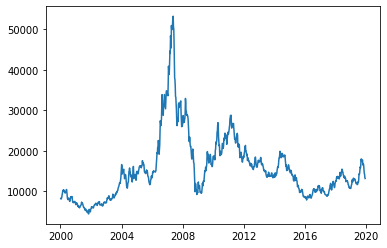

In [4]:
plt.plot(LME)

### Note About Preprocessing: 

#### For differenced data, to unscale, must concatenate the LAST VALUE OF THE ORIGINAL Y OF THE TRAINING SET, with the new PREDICTED SERIES OF SCALED_YHAT to use CUMSUM()

In [5]:
def preprocess(series, window_setting):
    moving_avg = series.rolling(window=window_setting).mean().shift()
    moving_avg_diff = series - moving_avg
    return moving_avg_diff
    
def unpreprocess(first, stationary_series):
    #first = training_y_series.last()
    '''With no gaps in time'''
    unscaled = np.r_[first ,stationary_series].cumsum()
    #unscaled = unscaled[1:]
    return unscaled
    

In [61]:
# TESTING UNSCALING 
'''
LME_stationary = preprocess(LME)
first = LME.first('D')
#LME_reversed = unpreprocess(first, LME_stationary)
LME_reversed = np.r_[first ,LME_stationary[1:]].cumsum()
LME_reversed = pd.DataFrame(LME_reversed)

#######################

y_test = LME_stationary['2018-10-14':]
original_y_test = LME['2018-10-14':]

# !!! NOTE MAKE SURE TO SET y_train as ONE WEEK BEFORE MANUALLY
original_y_train = LME[:'2018-10-07']

first = original_y_train.last('D')
LME_reversed = np.r_[first , y_test].cumsum()
LME_reversed = pd.DataFrame(LME_reversed)
LME_reversed = LME_reversed[1:]
LME_reversed.head()

#original_y
'''

"\nLME_stationary = preprocess(LME)\nfirst = LME.first('D')\n#LME_reversed = unpreprocess(first, LME_stationary)\nLME_reversed = np.r_[first ,LME_stationary[1:]].cumsum()\nLME_reversed = pd.DataFrame(LME_reversed)\n\n#######################\n\ny_test = LME_stationary['2018-10-14':]\noriginal_y_test = LME['2018-10-14':]\n\n# !!! NOTE MAKE SURE TO SET y_train as ONE WEEK BEFORE MANUALLY\noriginal_y_train = LME[:'2018-10-07']\n\nfirst = original_y_train.last('D')\nLME_reversed = np.r_[first , y_test].cumsum()\nLME_reversed = pd.DataFrame(LME_reversed)\nLME_reversed = LME_reversed[1:]\nLME_reversed.head()\n\n#original_y\n"

#### Take Out Trend

Pandas time series resampling options
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

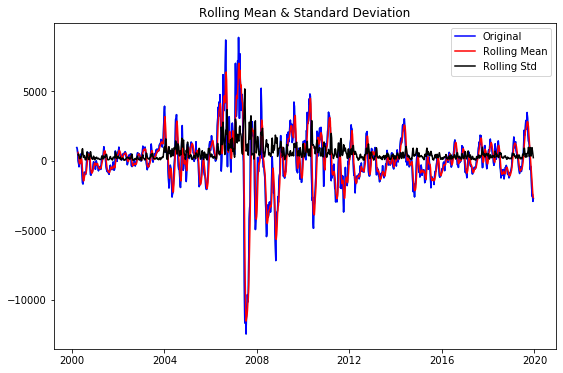

Results of Dickey-Fuller Test:
Test Statistic                -7.482431e+00
p-value                        4.733653e-11
#Lags Used                     1.000000e+01
Number of Observations Used    1.020000e+03
Critical Value (1%)           -3.436777e+00
Critical Value (5%)           -2.864378e+00
Critical Value (10%)          -2.568281e+00
dtype: float64


In [6]:
LME_stationary = preprocess(LME, 10)

#LME_log = np.log(LME)
LME_log = LME
rcParams['figure.figsize'] = 9, 6

#plt.plot(LME_log)
#plt.show()

window_setting= 10
moving_avg = LME_log.rolling(window=window_setting).mean()
#plt.plot(LME_log)
#plt.plot(moving_avg, color='red')
#plt.axvline('2018-5-1', color='red', linestyle='--')
#plt.show()

moving_diff = LME_log-moving_avg.shift()
moving_diff = moving_diff.dropna()
#moving_diff = moving_diff.to_frame()

plt.plot(LME_stationary)

test_stationarity(LME_stationary.dropna())

In [7]:
LME_stationary = preprocess(LME, window_setting)

list_one = list(LME_stationary.index)
list_two = list(LME_stationary)
df = pd.DataFrame(list(zip(list_one, list_two)), columns = ['ds', 'y'])
df.head()


df['lag1'] = df.y.shift(periods=1)
df['lag2'] = df.y.shift(periods=2)
df['lag3'] = df.y.shift(periods=3)
df['lag4'] = df.y.shift(periods=4)
df['lag5'] = df.y.shift(periods=5)

df['lag6'] = df.y.shift(periods=6)
df['lag7'] = df.y.shift(periods=7)
df['lag8'] = df.y.shift(periods=8)
df['lag9'] = df.y.shift(periods=9)
df['lag10'] = df.y.shift(periods=10)

df.index = df['ds']
df = df.iloc[:, 1:]

df = df.dropna()

df.head(10)

,y,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10
ds,,,,,,,,,,,
2000-05-28,423.565,482.525,-41.515,-77.155,-197.915,-425.925,-167.760,4.030,567.010,894.562,952.052
2000-06-04,-510.475,423.565,482.525,-41.515,-77.155,-197.915,-425.925,-167.760,4.030,567.010,894.562
2000-06-11,-1123.875,-510.475,423.565,482.525,-41.515,-77.155,-197.915,-425.925,-167.760,4.030,567.010
2000-06-18,-1596.715,-1123.875,-510.475,423.565,482.525,-41.515,-77.155,-197.915,-425.925,-167.760,4.030
2000-06-25,-1668.975,-1596.715,-1123.875,-510.475,423.565,482.525,-41.515,-77.155,-197.915,-425.925,-167.760
2000-07-02,-1405.840,-1668.975,-1596.715,-1123.875,-510.475,423.565,482.525,-41.515,-77.155,-197.915,-425.925
2000-07-09,-1006.340,-1405.840,-1668.975,-1596.715,-1123.875,-510.475,423.565,482.525,-41.515,-77.155,-197.915
2000-07-16,-818.340,-1006.340,-1405.840,-1668.975,-1596.715,-1123.875,-510.475,423.565,482.525,-41.515,-77.155
2000-07-23,-867.920,-818.340,-1006.340,-1405.840,-1668.975,-1596.715,-1123.875,-510.475,423.565,482.525,-41.515


## Linear Regression

IMPORTANT NOTE TO SELF: 
For smoothing using moving average, must RESCALE output predictions using inputs!! 

SECOND NOTE 2 SELF: 
for training/fitting/testing set... 

MODEL FOR DEPLOYMENT: 
Train a model that uses values from a year ago or OLDER to predict values and rescale according to moving averages... 



In [88]:
X = df[['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
y= df['y']

X

,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10
ds,,,,,,,,,,
2000-05-28,482.525,-41.515,-77.155,-197.915,-425.925,-167.760,4.030,567.010,894.562,952.052
2000-06-04,423.565,482.525,-41.515,-77.155,-197.915,-425.925,-167.760,4.030,567.010,894.562
2000-06-11,-510.475,423.565,482.525,-41.515,-77.155,-197.915,-425.925,-167.760,4.030,567.010
2000-06-18,-1123.875,-510.475,423.565,482.525,-41.515,-77.155,-197.915,-425.925,-167.760,4.030
2000-06-25,-1596.715,-1123.875,-510.475,423.565,482.525,-41.515,-77.155,-197.915,-425.925,-167.760
2000-07-02,-1668.975,-1596.715,-1123.875,-510.475,423.565,482.525,-41.515,-77.155,-197.915,-425.925
2000-07-09,-1405.840,-1668.975,-1596.715,-1123.875,-510.475,423.565,482.525,-41.515,-77.155,-197.915
2000-07-16,-1006.340,-1405.840,-1668.975,-1596.715,-1123.875,-510.475,423.565,482.525,-41.515,-77.155
2000-07-23,-818.340,-1006.340,-1405.840,-1668.975,-1596.715,-1123.875,-510.475,423.565,482.525,-41.515


In [78]:
X_test = X.loc['2018-10-14':  ,:]
y_test = y['2018-10-14':]

X_train = X.loc[:'2018-10-14', :]
X_train.tail()

,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10
ds,,,,,,,,,,
2018-09-16,-1298.375,-624.055,-674.675,-1055.780,-640.220,-946.915,-1051.995,-1229.055,-652.640,-463.470
2018-09-23,-1056.295,-1298.375,-624.055,-674.675,-1055.780,-640.220,-946.915,-1051.995,-1229.055,-652.640
2018-09-30,-784.375,-1056.295,-1298.375,-624.055,-674.675,-1055.780,-640.220,-946.915,-1051.995,-1229.055
2018-10-07,-469.735,-784.375,-1056.295,-1298.375,-624.055,-674.675,-1055.780,-640.220,-946.915,-1051.995
2018-10-14,-593.385,-469.735,-784.375,-1056.295,-1298.375,-624.055,-674.675,-1055.780,-640.220,-946.915


In [79]:
## Weekly train/test set dates
X_train = X.loc[:'2018-10-07', :]
y_train = y[:'2018-10-07']

## Daily training dates
#X_train = X.loc[:'2018-10-12', :]
#y_train = y[:'2018-10-12']

## Monthly training dates
#X_train = X.loc[:'2018-10-14', :]
#y_train = y[:'2018-10-14']



In [80]:
regressor = LinearRegression()

regressor.fit(X_train, y_train)
print(regressor.coef_)

y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index
# y_pred = y_pred.reindex(X_test.index)


[ 1.17461049 -0.33414092  0.1530693  -0.12307743  0.01999745  0.03820555
 -0.01276916  0.09736296 -0.26146162  0.11616423]


## Back to Scale before Performance Analysis

In [81]:
original_tail = LME.loc[y_train.index[-window_setting:]]

for key, item in y_pred.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    unscaled_result = item + rolling_avg
    original_tail = original_tail.append(pd.Series([unscaled_result]))

unscaled = pd.Series(original_tail)
unscaled = unscaled[window_setting:]
unscaled.index = y_test.index



In [82]:
original_tail = LME.loc[y_train.index[-window_setting:]]

for key, item in y_test.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    original_y = item + rolling_avg
    original_tail = original_tail.append(pd.Series([original_y]))


original_y = pd.Series(original_tail)
original_y = original_y[window_setting:]
original_y.index = y_test.index
original_y.head()

ds
2018-10-14    12642.6
2018-10-21    12399.5
2018-10-28    12157.1
2018-11-04    11676.1
2018-11-11    11645.1
dtype: float64

In [83]:
# Sanity check for unscaling! 

LME[LME.index=='2018-10-14']


#LME[LME.index=='2018-10-31']

Unnamed: 1
2018-10-14    12642.6
Freq: W-SUN, Name: Cash Price ($/MT), dtype: float64

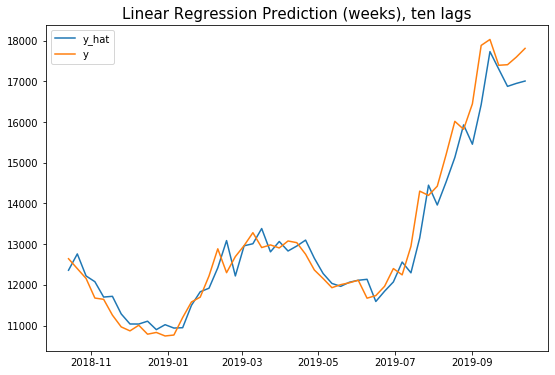

In [84]:
plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Linear Regression Prediction (weeks), ten lags', fontsize=15)

plt.show()

In [85]:
results = pd.DataFrame({'y_test': original_y, 'y_pred_unscaled': unscaled})
results['error'] = results['y_test'] - results['y_pred_unscaled']

results.head()

,y_test,y_pred_unscaled,error
ds,,,
2018-10-14,12642.6,12359.708976,282.891024
2018-10-21,12399.5,12760.338804,-360.838804
2018-10-28,12157.1,12218.849016,-61.749016
2018-11-04,11676.1,12078.328653,-402.228653
2018-11-11,11645.1,11700.695770,-55.595770


In [86]:
print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))


Mean Absolute Error: 342.8097954834033
Mean Squared Error: 209433.06603392854
Root Mean Squared Error: 457.6385757712395


# Other Kinds of Regression

Grid Search for RIDGE Regression


{'alpha': 1e-05}
Mean Absolute Error: 508.66785187341884
Mean Squared Error: 505857.9350449362
Root Mean Squared Error: 711.236905007703

{'alpha': 0.0001}
Mean Absolute Error: 508.6678518734635
Mean Squared Error: 505857.9350450282
Root Mean Squared Error: 711.2369050077676

{'alpha': 0.001}
Mean Absolute Error: 508.66785187392395
Mean Squared Error: 505857.9350459867
Root Mean Squared Error: 711.2369050084415

{'alpha': 0.01}
Mean Absolute Error: 508.6678518785121
Mean Squared Error: 505857.9350555347
Root Mean Squared Error: 711.2369050151536

{'alpha': 0.1}
Mean Absolute Error: 508.6678519243998
Mean Squared Error: 505857.93515100714
Root Mean Squared Error: 711.2369050822708

{'alpha': 1}
Mean Absolute Error: 508.66785238328
Mean Squared Error: 505857.93610574905
Root Mean Squared Error: 711.2369057534551

Ridge CV Results
{'alpha': 1e-05} 508.66785187341884
{'alpha': 0.0001} 508.6678518734635
{'alpha': 0.001} 508.66785187392395
{'alpha': 0.01} 508.6678518785121
{'alpha': 0.1} 50

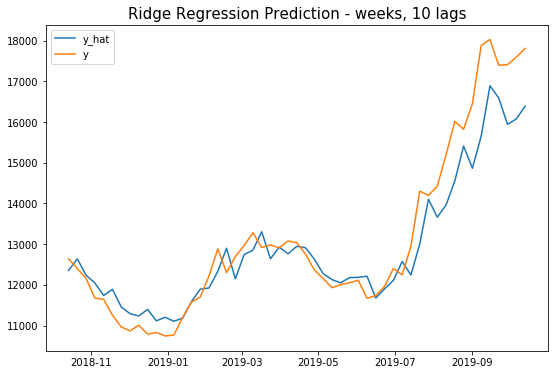

In [48]:
from sklearn import linear_model

params1= ParameterGrid({'alpha' : [ .00001 ,.0001, .001, .01, .1, 1]
                            })

cv_results = {}

for params in params1:

    regressor = linear_model.Ridge(**params, random_state=1)

    print()
    print(params)
    
    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index
    # y_pred = y_pred.reindex(X_test.index)

    original_tail = LME.loc[y_train.index[-window_setting:]]

    for key, item in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item + rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[4:]
    unscaled.index = y_test.index


    original_tail = LME.loc[y_train.index[-window_setting:]]

    for key, item in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item + rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[4:]
    original_y.index = y_test.index
    original_y.head()

    
    print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
    print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

    
    mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    cv_results[str(params)] = mae

    # To find the best/optimal parameters

    '''Calculates maximum test accuracy value and parameters'''
    #min_test_accuracy, min_parameters = 0, 0
    min_test_accuracy = 3000
    for key, value in cv_results.items():
        if value < min_test_accuracy:
            min_test_accuracy = value
            min_parameters = key
            
print()
print('Ridge CV Results')
for key, value in cv_results.items():
    print(key, value)

print()
print('Best Results:')
if min_test_accuracy==3000:
    print('error')
else:
    print('Minimum Test Accuracy: ', min_test_accuracy)
print('Best Parameters: ', min_parameters)
print()

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Ridge Regression Prediction - weeks, 10 lags', fontsize=15)

plt.show()


{'alpha': 1e-05}
Mean Absolute Error: 508.6678518722947
Mean Squared Error: 505857.9350498549
Root Mean Squared Error: 711.2369050111607

{'alpha': 0.0001}
Mean Absolute Error: 508.66785186219084
Mean Squared Error: 505857.93509406823
Root Mean Squared Error: 711.2369050422427

{'alpha': 0.001}
Mean Absolute Error: 508.66785176134897
Mean Squared Error: 505857.9355371461
Root Mean Squared Error: 711.2369053537268

{'alpha': 0.01}
Mean Absolute Error: 508.66785075465765
Mean Squared Error: 505857.9399757228
Root Mean Squared Error: 711.2369084740491

{'alpha': 0.1}
Mean Absolute Error: 508.6678406700274
Mean Squared Error: 505857.984241242
Root Mean Squared Error: 711.2369395927366

{'alpha': 1}
Mean Absolute Error: 508.66773995663465
Mean Squared Error: 505858.4265383587
Root Mean Squared Error: 711.2372505278099

Ridge CV Results
{'alpha': 1e-05} 508.6678518722947
{'alpha': 0.0001} 508.66785186219084
{'alpha': 0.001} 508.66785176134897
{'alpha': 0.01} 508.66785075465765
{'alpha': 0.1

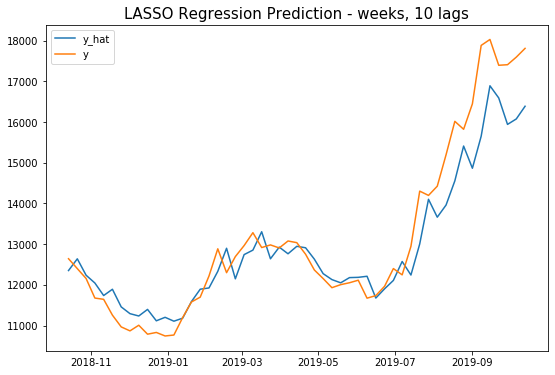

In [49]:
from sklearn import linear_model

params1= ParameterGrid({'alpha' : [ .00001 ,.0001, .001, .01, .1, 1]
                            })

cv_results = {}

for params in params1:

    regressor = linear_model.Lasso(**params, random_state=1)

    print()
    print(params)
    
    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index
    # y_pred = y_pred.reindex(X_test.index)

    original_tail = LME.loc[y_train.index[-window_setting:]]

    for key, item in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item + rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[4:]
    unscaled.index = y_test.index


    original_tail = LME.loc[y_train.index[-window_setting:]]

    for key, item in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item + rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[4:]
    original_y.index = y_test.index
    
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
    print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

    
    mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    cv_results[str(params)] = mae

    # To find the best/optimal parameters

    '''Calculates maximum test accuracy value and parameters'''
    #min_test_accuracy, min_parameters = 0, 0
    min_test_accuracy = 3000
    for key, value in cv_results.items():
        if value < min_test_accuracy:
            min_test_accuracy = value
            min_parameters = key
            
print()
print('Ridge CV Results')
for key, value in cv_results.items():
    print(key, value)

print()
print('Best Results:')
if min_test_accuracy==3000:
    print('error')
else:
    print('Minimum Test Accuracy: ', min_test_accuracy)
print('Best Parameters: ', min_parameters)
print()

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('LASSO Regression Prediction - weeks, 10 lags', fontsize=15)

plt.show()


{'learning_rate': 0.0001, 'n_estimators': 50}
Mean Absolute Error: 574.8037997410424
Mean Squared Error: 483222.34863135905
Root Mean Squared Error: 695.1419629337298

{'learning_rate': 0.0001, 'n_estimators': 100}
Mean Absolute Error: 595.2840588172246
Mean Squared Error: 510978.31563673273
Root Mean Squared Error: 714.8274726370921

{'learning_rate': 0.0001, 'n_estimators': 150}
Mean Absolute Error: 601.0299106677841
Mean Squared Error: 517623.27891333203
Root Mean Squared Error: 719.4604081624867

{'learning_rate': 0.0001, 'n_estimators': 200}
Mean Absolute Error: 615.3498053153019
Mean Squared Error: 532527.0706975064
Root Mean Squared Error: 729.7445242668878

{'learning_rate': 0.0001, 'n_estimators': 250}
Mean Absolute Error: 606.6726767544066
Mean Squared Error: 522805.51680960885
Root Mean Squared Error: 723.0529142528982

{'learning_rate': 0.0001, 'n_estimators': 300}
Mean Absolute Error: 604.8883121683652
Mean Squared Error: 517446.95795022935
Root Mean Squared Error: 719.33

Mean Absolute Error: 1633.16653065594
Mean Squared Error: 3918469.289605975
Root Mean Squared Error: 1979.5123868281237

{'learning_rate': 0.3, 'n_estimators': 300}
Mean Absolute Error: 1751.5813914723128
Mean Squared Error: 4524438.704825738
Root Mean Squared Error: 2127.072801957126

{'learning_rate': 0.3, 'n_estimators': 350}
Mean Absolute Error: 1680.8495220753825
Mean Squared Error: 4143063.586975976
Root Mean Squared Error: 2035.4516911427734

{'learning_rate': 0.3, 'n_estimators': 400}
Mean Absolute Error: 1786.6619368603428
Mean Squared Error: 4758542.672071132
Root Mean Squared Error: 2181.4084147795734

{'learning_rate': 0.3, 'n_estimators': 450}
Mean Absolute Error: 1901.1227030084578
Mean Squared Error: 5479841.597812226
Root Mean Squared Error: 2340.9061488689003

Adaboost CV Results
{'learning_rate': 0.0001, 'n_estimators': 50} 574.8037997410424
{'learning_rate': 0.0001, 'n_estimators': 100} 595.2840588172246
{'learning_rate': 0.0001, 'n_estimators': 150} 601.029910667784

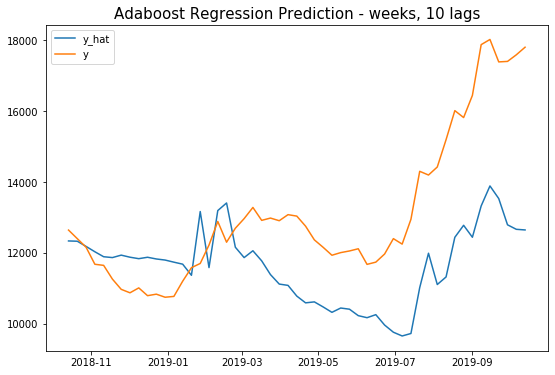

In [50]:
from sklearn.ensemble import AdaBoostRegressor

params1= ParameterGrid({'n_estimators' : [50, 100, 150, 200, 250, 300, 350, 400, 450],
                            'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]})

cv_results = {}

for params in params1:

    regressor = AdaBoostRegressor(**params, random_state=1)

    print()
    print(params)
    
    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index
    # y_pred = y_pred.reindex(X_test.index)


    original_tail = LME.loc[y_train.index[-window_setting:]]

    for key, item in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item + rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[4:]
    unscaled.index = y_test.index


    original_tail = LME.loc[y_train.index[-window_setting:]]

    for key, item in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item + rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[4:]
    original_y.index = y_test.index
    
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
    print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

    
    mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    cv_results[str(params)] = mae

    # To find the best/optimal parameters

    '''Calculates maximum test accuracy value and parameters'''
    #min_test_accuracy, min_parameters = 0, 0
    min_test_accuracy = 3000
    for key, value in cv_results.items():
        if value < min_test_accuracy:
            min_test_accuracy = value
            min_parameters = key
            
print()
print('Adaboost CV Results')
for key, value in cv_results.items():
    print(key, value)

print()
print('Best Results:')
if min_test_accuracy==3000:
    print('error')
else:
    print('Minimum Test Accuracy: ', min_test_accuracy)
print('Best Parameters: ', min_parameters)
print()

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Adaboost Regression Prediction - weeks, 10 lags', fontsize=15)

plt.show()


{'min_samples_leaf': 0.15, 'n_estimators': 50}
Mean Absolute Error: 834.791081314725
Mean Squared Error: 1090446.001753461
Root Mean Squared Error: 1044.2442251472885

{'min_samples_leaf': 0.15, 'n_estimators': 100}
Mean Absolute Error: 792.1484030443305
Mean Squared Error: 989733.3573681887
Root Mean Squared Error: 994.8534351190575

{'min_samples_leaf': 0.15, 'n_estimators': 150}
Mean Absolute Error: 771.8338576545623
Mean Squared Error: 949520.8783524801
Root Mean Squared Error: 974.4336192642781

{'min_samples_leaf': 0.15, 'n_estimators': 200}
Mean Absolute Error: 778.3222445654145
Mean Squared Error: 973691.088335065
Root Mean Squared Error: 986.7578671260063

{'min_samples_leaf': 0.15, 'n_estimators': 250}
Mean Absolute Error: 788.0956044535708
Mean Squared Error: 997369.9732091366
Root Mean Squared Error: 998.6841208355806

{'min_samples_leaf': 0.15, 'n_estimators': 300}
Mean Absolute Error: 789.2695820260648
Mean Squared Error: 1002422.2227292005
Root Mean Squared Error: 1001.

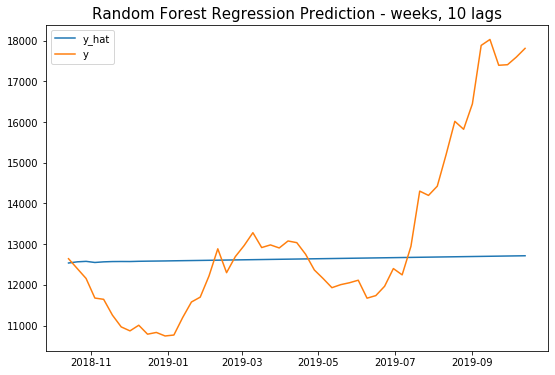

In [51]:
from sklearn.ensemble import RandomForestRegressor

params1= ParameterGrid({'n_estimators' : [50, 100, 150, 200, 250, 300, 350, 400, 450],
                            'min_samples_leaf': [ .15,  .25, .35, .45]})

cv_results = {}

for params in params1:

    regressor = RandomForestRegressor(**params, random_state=1)

    print()
    print(params)
    
    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index
    # y_pred = y_pred.reindex(X_test.index)

    
    original_tail = LME.loc[y_train.index[-window_setting:]]

    for key, item in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item + rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[4:]
    unscaled.index = y_test.index


    original_tail = LME.loc[y_train.index[-window_setting:]]

    for key, item in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item + rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[4:]
    original_y.index = y_test.index
    
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
    print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

    
    mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    cv_results[str(params)] = mae

    # To find the best/optimal parameters

    '''Calculates maximum test accuracy value and parameters'''
    #min_test_accuracy, min_parameters = 0, 0
    min_test_accuracy = 3000
    for key, value in cv_results.items():
        if value < min_test_accuracy:
            min_test_accuracy = value
            min_parameters = key
            
print()
print('Random Forest CV Results')
for key, value in cv_results.items():
    print(key, value)

print()
print('Best Results:')
if min_test_accuracy==3000:
    print('error')
else:
    print('Minimum Test Accuracy: ', min_test_accuracy)
print('Best Parameters: ', min_parameters)
print()

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Random Forest Regression Prediction - weeks, 10 lags', fontsize=15)

plt.show()


K:  1
Mean Absolute Error: 944.7809458913387
Mean Squared Error: 1310330.9992789528
Root Mean Squared Error: 1144.6969027995808

K:  2
Mean Absolute Error: 818.102724629712
Mean Squared Error: 889841.1180769285
Root Mean Squared Error: 943.3139021963625

K:  3
Mean Absolute Error: 835.6868943787193
Mean Squared Error: 934188.8421699452
Root Mean Squared Error: 966.5344495515642

K:  4
Mean Absolute Error: 904.3598603819179
Mean Squared Error: 1055776.6001042698
Root Mean Squared Error: 1027.5099026794194

K:  5
Mean Absolute Error: 750.2851002225964
Mean Squared Error: 814513.7582812344
Root Mean Squared Error: 902.504159703009

K:  6
Mean Absolute Error: 737.7598308742575
Mean Squared Error: 790251.660815002
Root Mean Squared Error: 888.9610007278171

K:  7
Mean Absolute Error: 692.9033247644297
Mean Squared Error: 711925.4291146708
Root Mean Squared Error: 843.7567357447707


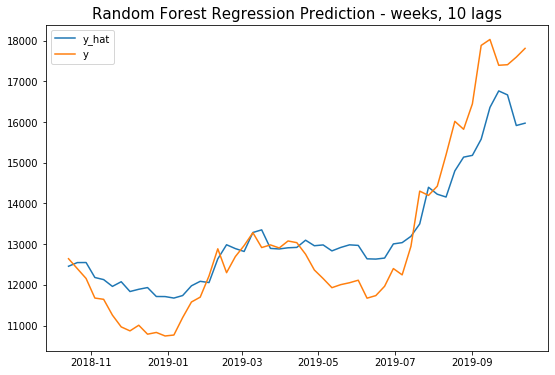

{"{'min_samples_leaf': 0.45, 'n_estimators': 450}": 692.9033247644297}


In [52]:
from sklearn import neighbors

cv_results = {}

for K in range(7):
    K = K+1
    regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

    print()
    print('K: ', K)
    
    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index
    # y_pred = y_pred.reindex(X_test.index)


    original_tail = LME.loc[y_train.index[-window_setting:]]

    for key, item in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item + rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[4:]
    unscaled.index = y_test.index


    original_tail = LME.loc[y_train.index[-window_setting:]]

    for key, item in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item + rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[4:]
    original_y.index = y_test.index
    
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
    print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

    
    mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    cv_results[str(params)] = mae

    # To find the best/optimal parameters


plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Random Forest Regression Prediction - weeks, 10 lags', fontsize=15)

plt.show()

print(cv_results)

MAE for scaled results:  17.988125233103716

Mean Absolute Error: 520.7989059453641
Mean Squared Error: 470480.1516187292
Root Mean Squared Error: 685.915557207102
Polynomial MAE of Degree = 2:  520.7989059453641


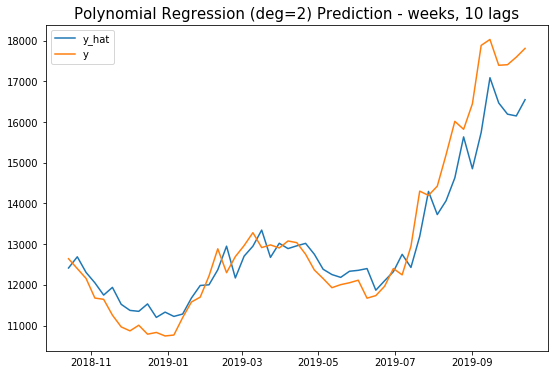

In [53]:
from sklearn.preprocessing import PolynomialFeatures
polynomial_features= PolynomialFeatures(degree=2)

X_poly = polynomial_features.fit_transform(X_train)

regressor = LinearRegression()
regressor.fit(X_poly, y_train)

X_poly_test = polynomial_features.fit_transform(X_test)
y_poly_pred = regressor.predict(X_poly_test)
y_poly_pred = pd.Series(y_poly_pred)
y_poly_pred.index = y_test.index

mae = np.sqrt(metrics.mean_absolute_error(y_test,y_poly_pred))
print('MAE for scaled results: ', mae)
print()

original_tail = LME.loc[y_train.index[-window_setting:]]

for key, item in y_poly_pred.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    unscaled_result = item + rolling_avg
    original_tail = original_tail.append(pd.Series([unscaled_result]))

unscaled = pd.Series(original_tail)
unscaled = unscaled[4:]
unscaled.index = y_test.index


original_tail = LME.loc[y_train.index[-window_setting:]]

for key, item in y_test.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    original_y = item + rolling_avg
    original_tail = original_tail.append(pd.Series([original_y]))


original_y = pd.Series(original_tail)
original_y = original_y[4:]
original_y.index = y_test.index



print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))


mae = metrics.mean_absolute_error(original_y, unscaled)
print('Polynomial MAE of Degree = 2: ', mae)
#print('kfold test accuracy =', kfold_test_accuracy)

# To find the best/optimal parameters


plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Polynomial Regression (deg=2) Prediction - weeks, 10 lags', fontsize=15)

plt.show()


MAE for scaled results:  18.393707138979423

Mean Absolute Error: 525.2406364163761
Mean Squared Error: 432701.47568446357
Root Mean Squared Error: 657.8004831895942
Polynomial MAE of Degree = 3:  525.2406364163761


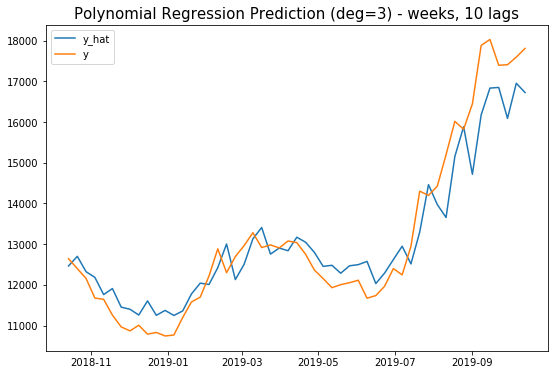

In [54]:
polynomial_features= PolynomialFeatures(degree=3)

X_poly = polynomial_features.fit_transform(X_train)

regressor = LinearRegression()
regressor.fit(X_poly, y_train)

X_poly_test = polynomial_features.fit_transform(X_test)
y_poly_pred = regressor.predict(X_poly_test)
y_poly_pred = pd.Series(y_poly_pred)
y_poly_pred.index = y_test.index

mae = np.sqrt(metrics.mean_absolute_error(y_test,y_poly_pred))
print('MAE for scaled results: ', mae)
print()

original_tail = LME.loc[y_train.index[-window_setting:]]

for key, item in y_poly_pred.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    unscaled_result = item + rolling_avg
    original_tail = original_tail.append(pd.Series([unscaled_result]))

unscaled = pd.Series(original_tail)
unscaled = unscaled[4:]
unscaled.index = y_test.index


original_tail = LME.loc[y_train.index[-window_setting:]]

for key, item in y_test.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    original_y = item + rolling_avg
    original_tail = original_tail.append(pd.Series([original_y]))


original_y = pd.Series(original_tail)
original_y = original_y[4:]
original_y.index = y_test.index




print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))


mae = metrics.mean_absolute_error(original_y, unscaled)
print('Polynomial MAE of Degree = 3: ', mae)
#print('kfold test accuracy =', kfold_test_accuracy)

# To find the best/optimal parameters


plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Polynomial Regression Prediction (deg=3) - weeks, 10 lags', fontsize=15)

plt.show()


MAE for scaled results:  134.2621730498453

Mean Absolute Error: 30391.113128702647
Mean Squared Error: 3014586442.660404
Root Mean Squared Error: 54905.24968216067
Polynomial MAE of Degree = 2:  30391.113128702647


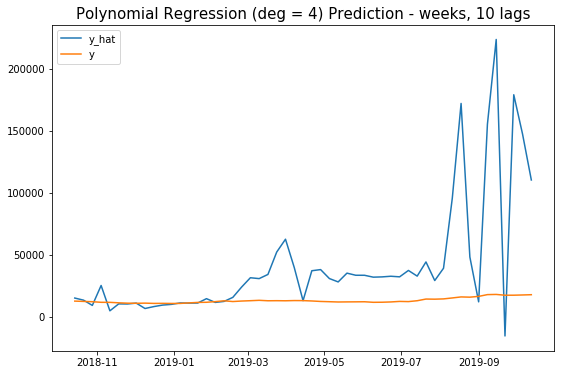

In [55]:
polynomial_features= PolynomialFeatures(degree=4)

X_poly = polynomial_features.fit_transform(X_train)

regressor = LinearRegression()
regressor.fit(X_poly, y_train)

X_poly_test = polynomial_features.fit_transform(X_test)
y_poly_pred = regressor.predict(X_poly_test)
y_poly_pred = pd.Series(y_poly_pred)
y_poly_pred.index = y_test.index

mae = np.sqrt(metrics.mean_absolute_error(y_test,y_poly_pred))
print('MAE for scaled results: ', mae)
print()

original_tail = LME.loc[y_train.index[-window_setting:]]

for key, item in y_poly_pred.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    unscaled_result = item + rolling_avg
    original_tail = original_tail.append(pd.Series([unscaled_result]))

unscaled = pd.Series(original_tail)
unscaled = unscaled[4:]
unscaled.index = y_test.index


original_tail = LME.loc[y_train.index[-window_setting:]]

for key, item in y_test.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    original_y = item + rolling_avg
    original_tail = original_tail.append(pd.Series([original_y]))


original_y = pd.Series(original_tail)
original_y = original_y[4:]
original_y.index = y_test.index


print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))


mae = metrics.mean_absolute_error(original_y, unscaled)
print('Polynomial MAE of Degree = 2: ', mae)
#print('kfold test accuracy =', kfold_test_accuracy)

# To find the best/optimal parameters


plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Polynomial Regression (deg = 4) Prediction - weeks, 10 lags', fontsize=15)

plt.show()


In [45]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(((y_pred - y_true) **2).mean())
    #return np.mean(np.abs((y_true - y_pred) / y_true))*100


In [47]:
print('mape', mean_absolute_percentage_error(cmp_df['y'], cmp_df['yhat']))

print('rmse', root_mean_squared_error(cmp_df['y'], cmp_df['yhat']))

mape 219.83967767924054
rmse 0.05529372373011725


In [97]:
pd.DataFrame({'mean':tester.rolling(window=3).mean(), 'original': tester})

,mean,original
0,NaN,1.0
1,NaN,2.0
2,2.000000,3.0
3,3.000000,4.0
4,6.000000,11.0
5,7.000000,6.0
6,8.000000,7.0
7,7.000000,8.0
8,8.000000,9.0
9,5.833333,0.5
